In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = xr.open_dataset('../data/20101101.nc')
data

<xarray.Dataset> Size: 264MB
Dimensions:                         (time: 286, y: 480, x: 480)
Coordinates:
  * x                               (x) int32 2kB 549850 550350 ... 789350
  * y                               (y) int32 2kB 5271250 5270750 ... 5031750
  * time                            (time) datetime64[ns] 2kB 2010-11-01 ... ...
Data variables:
    transverse_mercator             |S1 1B ...
    equivalent_reflectivity_factor  (time, y, x) float32 264MB ...
Attributes:
    Conventions:         CF-1.7
    GDAL_AREA_OR_POINT:  Area
    title:               MAX(Z) Reflectivity day 2010-11-01
    institution:         Meteotrentino, Fondazione Bruno Kessler
    source:              radar observation mt.Macaion
    site_lat_lon_elev:   46.494002, 11.208826, 1876
    references:          original dataset https://doi.org/10.5281/zenodo.3577451
    comments:            NetCDF generation code https://github.com/MPBA/TAASR...
    chunks:              164 122
    tags:                rain snow

# TAASRAD19数据集分析教程

## 问题解答

### 1. 为什么看不到Data variables的值？

**原因分析：**
- 数据使用了**分块存储（chunking）**，chunks: 164 122
- 数据大小264MB，xarray默认不会立即加载所有数据到内存
- 这是**延迟加载（lazy loading）**机制，只有在实际访问数据时才会读取

### 2. Coordinates的x和y是什么？

**坐标系统解释：**
- **x, y**: 这是**UTM坐标系统**（通用横轴墨卡托投影）
- x范围: 549850 到 789350 (东西方向，单位：米)
- y范围: 5271250 到 5031750 (南北方向，单位：米)
- 这是**地理坐标**，不是像素坐标
- 雷达站点位置: 46.494002°N, 11.208826°E, 海拔1876米


In [5]:
# 1. 查看数据的基本信息
print("=== 数据集基本信息 ===")
print(f"数据维度: {data.dims}")
print(f"数据大小: {data.nbytes / 1024**2:.1f} MB")
print(f"时间范围: {data.time.min().values} 到 {data.time.max().values}")
print(f"时间步数: {len(data.time)}")
print(f"时间间隔: {pd.Timedelta(data.time[1].values - data.time[0].values)}")

print("\n=== 坐标信息 ===")
print(f"X坐标范围: {data.x.min().values} 到 {data.x.max().values} (米)")
print(f"Y坐标范围: {data.y.min().values} 到 {data.y.max().values} (米)")
print(f"空间分辨率: {(data.x[1] - data.x[0]).values} 米")


=== 数据集基本信息 ===
数据维度: FrozenMappingWarningOnValuesAccess({'time': 286, 'y': 480, 'x': 480})
数据大小: 251.4 MB
时间范围: 2010-11-01T00:00:00.000000000 到 2010-11-01T23:55:00.000000000
时间步数: 286
时间间隔: 0 days 00:05:00

=== 坐标信息 ===
X坐标范围: 549850 到 789350 (米)
Y坐标范围: 5031750 到 5271250 (米)
空间分辨率: 500 米


In [6]:
# 2. 查看雷达反射率数据
print("=== 雷达反射率数据信息 ===")
reflectivity = data['equivalent_reflectivity_factor']
print(f"变量名: {reflectivity.name}")
print(f"数据类型: {reflectivity.dtype}")
print(f"数据形状: {reflectivity.shape}")
print(f"单位: {reflectivity.attrs.get('units', '未知')}")

# 查看数据的实际值（只加载一小部分数据）
print("\n=== 数据值示例 ===")
# 选择第一个时间步的一小部分数据
sample_data = reflectivity.isel(time=0, x=slice(0, 50), y=slice(0, 50))
print(f"样本数据形状: {sample_data.shape}")
print(f"样本数据值:\n{sample_data.values}")

# 查看数据的统计信息
print(f"\n=== 数据统计信息 ===")
print(f"最小值: {sample_data.min().values}")
print(f"最大值: {sample_data.max().values}")
print(f"平均值: {sample_data.mean().values:.2f}")
print(f"非零值数量: {(sample_data > 0).sum().values}")


=== 雷达反射率数据信息 ===
变量名: equivalent_reflectivity_factor
数据类型: float32
数据形状: (286, 480, 480)
单位: dBZ

=== 数据值示例 ===
样本数据形状: (50, 50)
样本数据值:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

=== 数据统计信息 ===
最小值: 0.0
最大值: 0.0
平均值: 0.00
非零值数量: 0


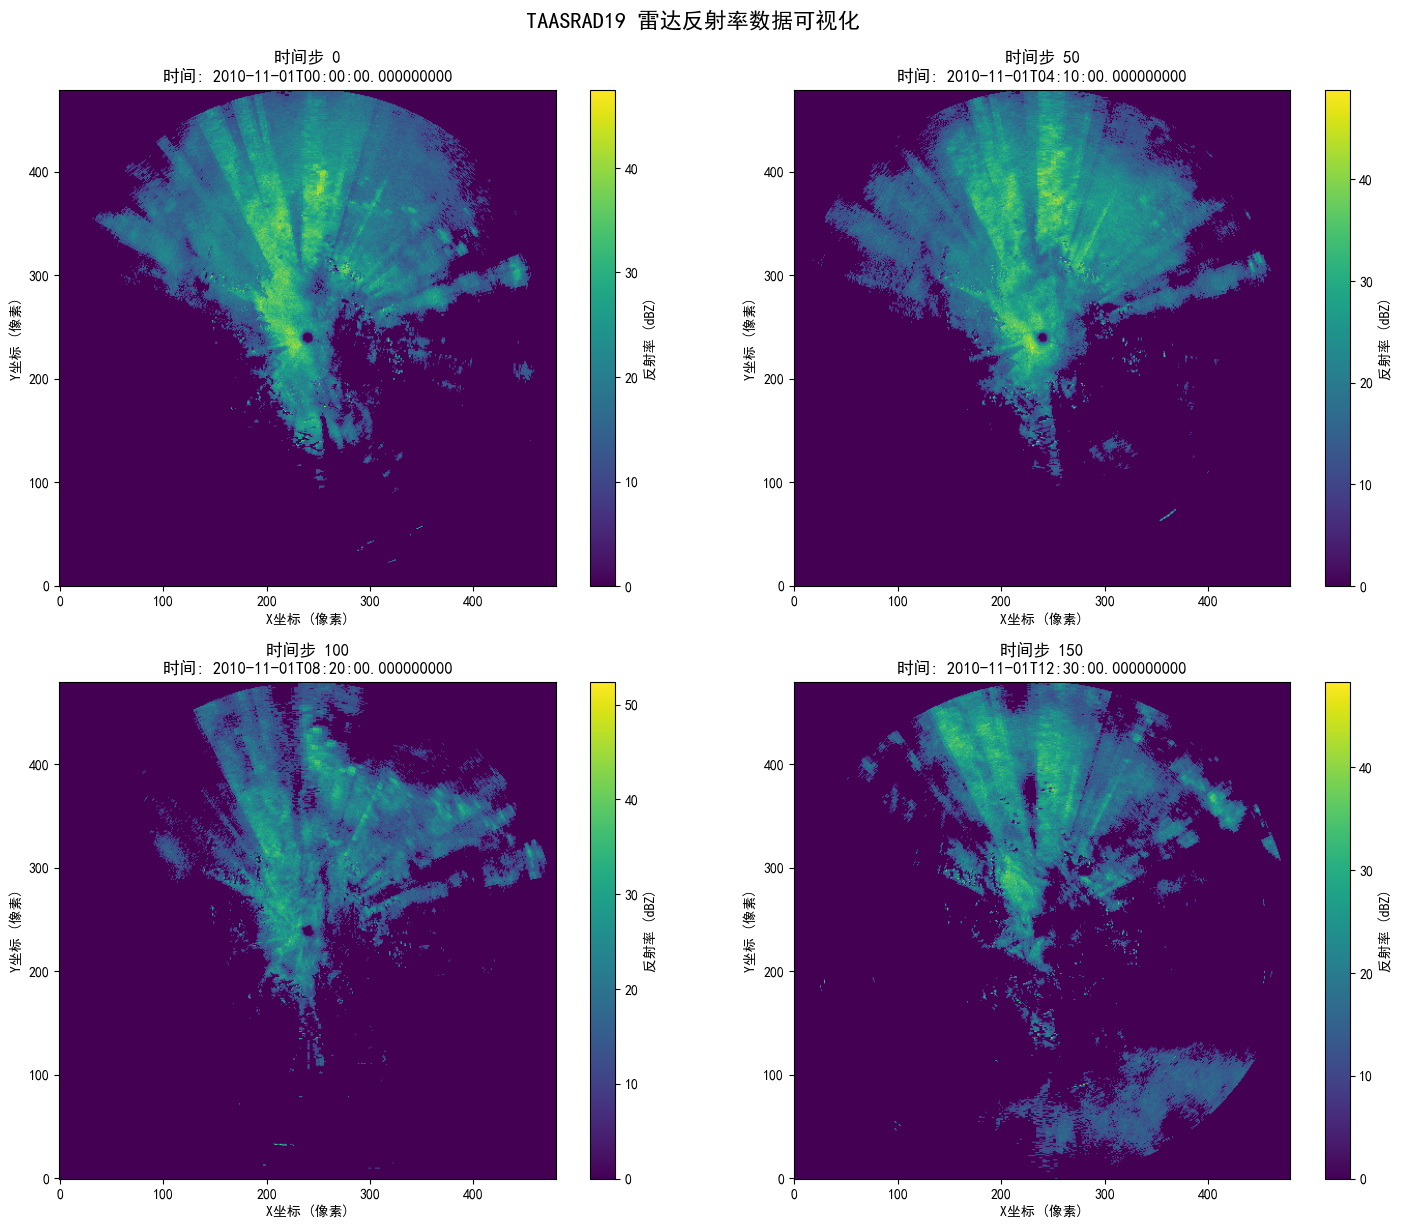

In [7]:
# 3. 可视化雷达数据
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 选择几个不同的时间步进行可视化
time_indices = [0, 50, 100, 150]
titles = ['时间步 0', '时间步 50', '时间步 100', '时间步 150']

for i, (time_idx, title) in enumerate(zip(time_indices, titles)):
    ax = axes[i//2, i%2]
    
    # 获取指定时间步的数据
    radar_data = reflectivity.isel(time=time_idx)
    
    # 创建图像
    im = ax.imshow(radar_data.values, cmap='viridis', origin='lower')
    ax.set_title(f'{title}\n时间: {data.time.isel(time=time_idx).values}')
    ax.set_xlabel('X坐标 (像素)')
    ax.set_ylabel('Y坐标 (像素)')
    
    # 添加颜色条
    plt.colorbar(im, ax=ax, label='反射率 (dBZ)')

plt.tight_layout()
plt.suptitle('TAASRAD19 雷达反射率数据可视化', y=1.02, fontsize=16)
plt.show()


In [20]:
# 4. 分析数据的物理意义
print("=== 雷达反射率物理意义分析 ===")

# 获取完整数据集的统计信息（这可能需要一些时间）
print("正在计算全数据集的统计信息...")
full_stats = reflectivity.load()  # 强制加载所有数据到内存

print(f"全数据集统计:")
print(f"  最小值: {full_stats.min().values:.2f} dBZ")
print(f"  最大值: {full_stats.max().values:.2f} dBZ")
print(f"  平均值: {full_stats.mean().values:.2f} dBZ")
print(f"  标准差: {full_stats.std().values:.2f} dBZ")

# 分析不同反射率值的含义
print(f"\n=== 反射率值含义 ===")
print("dBZ值含义:")
print("  < 10 dBZ: 很弱的回波，可能是噪声")
print("  10-20 dBZ: 轻雨或毛毛雨")
print("  20-30 dBZ: 小雨")
print("  30-40 dBZ: 中雨")
print("  40-50 dBZ: 大雨")
print("  > 50 dBZ: 暴雨或冰雹")

# 统计不同强度降水的像素数量
light_rain = (full_stats >= 10) & (full_stats < 20)
moderate_rain = (full_stats >= 20) & (full_stats < 30)
heavy_rain = (full_stats >= 30) & (full_stats < 40)
very_heavy_rain = (full_stats >= 40)
miss = (full_stats == 0)

print(f"\n=== 降水强度分布 ===")
print(f"轻雨像素数: {light_rain.sum().values:,}")
print(f"中雨像素数: {moderate_rain.sum().values:,}")
print(f"大雨像素数: {heavy_rain.sum().values:,}")
print(f"暴雨像素数: {very_heavy_rain.sum().values:,}")
print(f"总像素数: {full_stats.size:,}")
print(f"缺失帧: {miss.all(dim=['x','y']).sum().values:,}")


=== 雷达反射率物理意义分析 ===
正在计算全数据集的统计信息...
全数据集统计:
  最小值: 0.00 dBZ
  最大值: 52.50 dBZ
  平均值: 4.40 dBZ
  标准差: 8.68 dBZ

=== 反射率值含义 ===
dBZ值含义:
  < 10 dBZ: 很弱的回波，可能是噪声
  10-20 dBZ: 轻雨或毛毛雨
  20-30 dBZ: 小雨
  30-40 dBZ: 中雨
  40-50 dBZ: 大雨
  > 50 dBZ: 暴雨或冰雹

=== 降水强度分布 ===
轻雨像素数: 8,678,957
中雨像素数: 5,167,749
大雨像素数: 1,076,790
暴雨像素数: 23,954
总像素数: 65,894,400
缺失帧: 0


=== 时间序列分析 ===


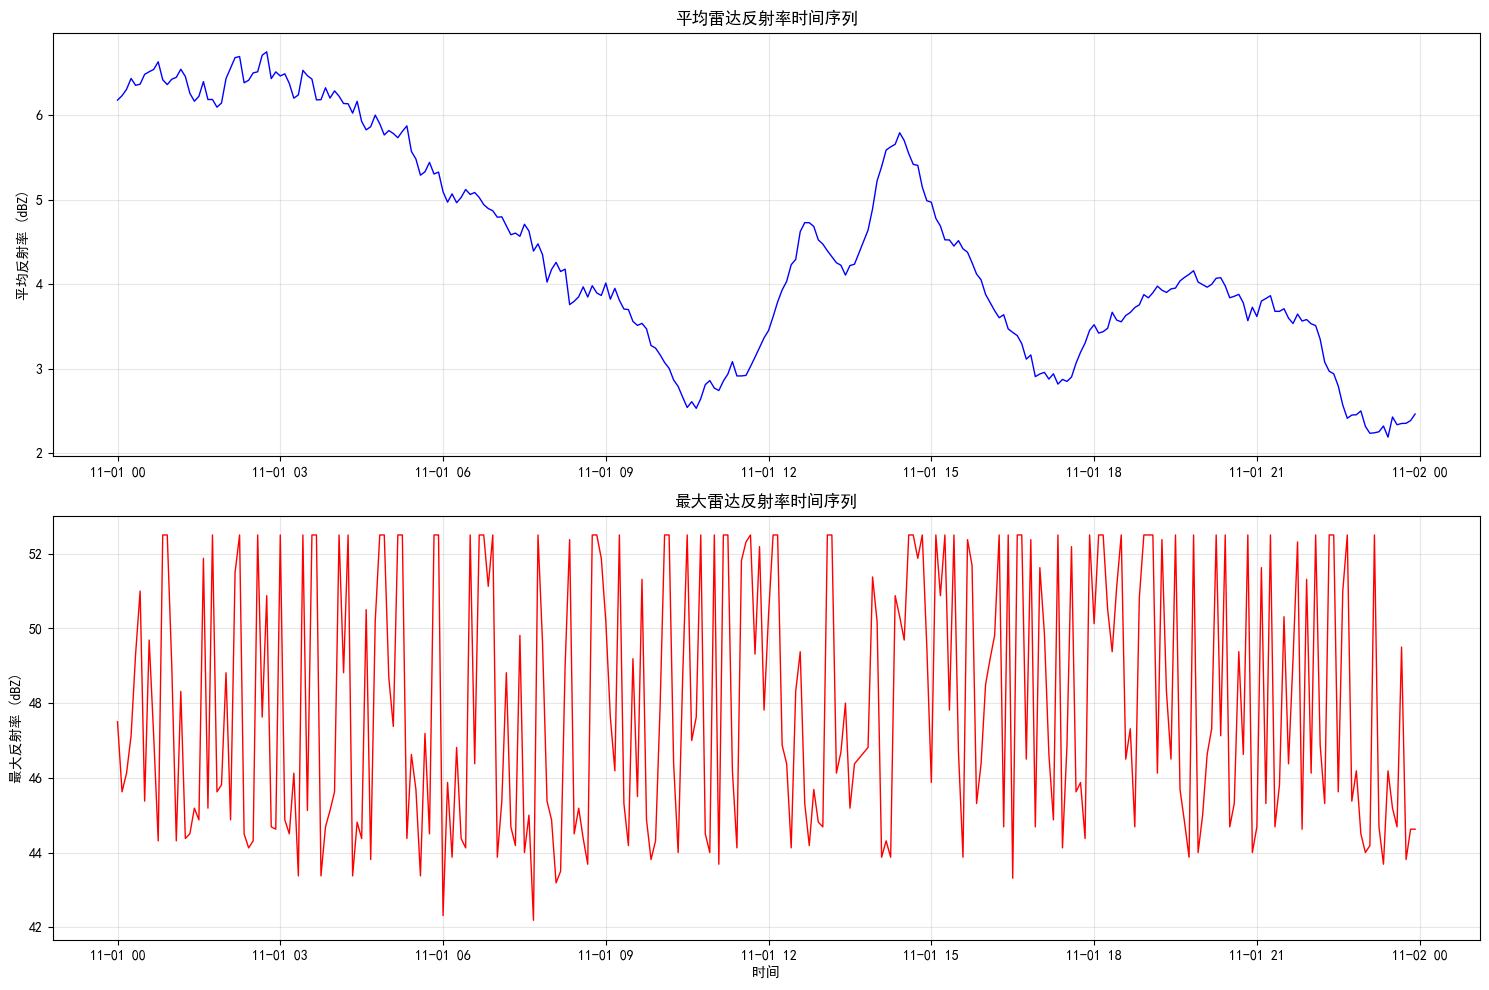


=== 降水事件分析 ===
降水阈值: 20 dBZ
检测到降水的时间步数: 286
降水时间比例: 100.0%
第一次降水时间: 2010-11-01T00:00:00.000000000
最后一次降水时间: 2010-11-01T23:55:00.000000000
最强降水时间: 2010-11-01T00:50:00.000000000
最强降水强度: 52.5 dBZ


In [9]:
# 5. 时间序列分析
print("=== 时间序列分析 ===")

# 计算每个时间步的平均反射率
mean_reflectivity = reflectivity.mean(dim=['x', 'y'])
max_reflectivity = reflectivity.max(dim=['x', 'y'])

# 创建时间序列图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 平均反射率时间序列
ax1.plot(data.time, mean_reflectivity, 'b-', linewidth=1)
ax1.set_title('平均雷达反射率时间序列')
ax1.set_ylabel('平均反射率 (dBZ)')
ax1.grid(True, alpha=0.3)

# 最大反射率时间序列
ax2.plot(data.time, max_reflectivity, 'r-', linewidth=1)
ax2.set_title('最大雷达反射率时间序列')
ax2.set_ylabel('最大反射率 (dBZ)')
ax2.set_xlabel('时间')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 分析降水事件
print(f"\n=== 降水事件分析 ===")
# 定义降水阈值（20 dBZ以上认为是有效降水）
rain_threshold = 20
rain_events = max_reflectivity > rain_threshold
rain_times = data.time[rain_events]

print(f"降水阈值: {rain_threshold} dBZ")
print(f"检测到降水的时间步数: {rain_events.sum().values}")
print(f"降水时间比例: {rain_events.sum().values / len(data.time) * 100:.1f}%")

if len(rain_times) > 0:
    print(f"第一次降水时间: {rain_times[0].values}")
    print(f"最后一次降水时间: {rain_times[-1].values}")
    print(f"最强降水时间: {data.time[max_reflectivity.argmax()].values}")
    print(f"最强降水强度: {max_reflectivity.max().values:.1f} dBZ")


## 关于transverse_mercator变量

### 什么是transverse_mercator？

`transverse_mercator`是一个**坐标参考系统（CRS）**的标识符，它表示数据使用的是**横轴墨卡托投影**。

**横轴墨卡托投影的特点：**
- 是一种**圆柱投影**，圆柱轴与地球旋转轴垂直
- 主要用于**UTM坐标系统**（通用横轴墨卡托投影）
- 在局部区域内**角度和形状保持良好**
- 适合用于**中纬度地区**的精确测量

### 为什么看起来是空的？

这个变量通常只包含**元数据信息**，而不是实际的地理数据。它主要用于：
1. **标识坐标系统**：告诉软件这个数据使用什么投影
2. **地理配准**：帮助GIS软件正确显示数据
3. **坐标转换**：支持不同坐标系统之间的转换


In [10]:
# 6. 分析transverse_mercator变量
print("=== transverse_mercator变量分析 ===")

# 获取transverse_mercator变量
transverse_mercator = data['transverse_mercator']
print(f"变量类型: {type(transverse_mercator)}")
print(f"数据类型: {transverse_mercator.dtype}")
print(f"数据形状: {transverse_mercator.shape}")
print(f"数据大小: {transverse_mercator.nbytes} 字节")

# 查看变量的属性
print(f"\n=== 变量属性 ===")
for attr_name, attr_value in transverse_mercator.attrs.items():
    print(f"{attr_name}: {attr_value}")

# 尝试查看实际值
print(f"\n=== 实际值 ===")
try:
    values = transverse_mercator.values
    print(f"值: {values}")
    print(f"值类型: {type(values)}")
    if hasattr(values, 'decode'):
        print(f"解码后的值: {values.decode()}")
except Exception as e:
    print(f"无法读取值: {e}")

# 检查是否是坐标参考系统信息
print(f"\n=== 坐标参考系统信息 ===")
if hasattr(data, 'crs') or 'crs' in data.attrs:
    print("找到CRS信息")
    if hasattr(data, 'crs'):
        print(f"CRS: {data.crs}")
    if 'crs' in data.attrs:
        print(f"CRS属性: {data.attrs['crs']}")
else:
    print("未找到明确的CRS信息")

# 查看所有属性
print(f"\n=== 数据集所有属性 ===")
for attr_name, attr_value in data.attrs.items():
    print(f"{attr_name}: {attr_value}")


=== transverse_mercator变量分析 ===
变量类型: <class 'xarray.core.dataarray.DataArray'>
数据类型: |S1
数据形状: ()
数据大小: 1 字节

=== 变量属性 ===
grid_mapping_name: transverse_mercator
longitude_of_central_meridian: 9.0
false_easting: 500000.0
false_northing: 0.0
latitude_of_projection_origin: 0.0
scale_factor_at_central_meridian: 0.9996
long_name: CRS definition
longitude_of_prime_meridian: 0.0
semi_major_axis: 6378137.0
inverse_flattening: 298.257223563
spatial_ref: PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AX

=== 坐标系统详细分析 ===
UTM坐标系统信息:
X坐标范围: 549850 到 789350
Y坐标范围: 5031750 到 5271250
X方向覆盖范围: 239500 米 (239.5 公里)
Y方向覆盖范围: 239500 米 (239.5 公里)
X方向分辨率: 500 米
Y方向分辨率: -500 米

=== 雷达站点信息 ===
纬度: 46.494002°
经度: 11.208826°
海拔: 1876 米
雷达覆盖半径: 119750.0 米 (119.8 公里)


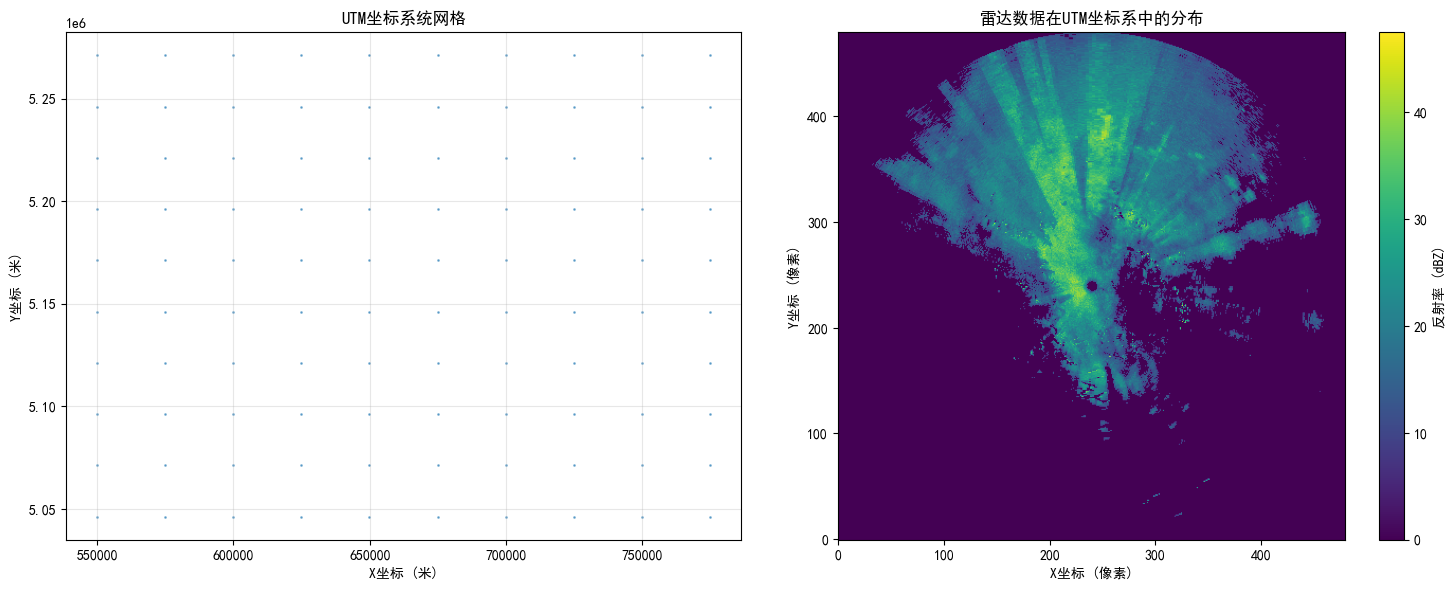

In [11]:
# 7. 坐标系统详细分析
print("=== 坐标系统详细分析 ===")

# 分析UTM坐标系统
print("UTM坐标系统信息:")
print(f"X坐标范围: {data.x.min().values} 到 {data.x.max().values}")
print(f"Y坐标范围: {data.y.min().values} 到 {data.y.max().values}")

# 计算覆盖的地理区域
x_range = data.x.max().values - data.x.min().values
y_range = data.y.max().values - data.y.min().values
print(f"X方向覆盖范围: {x_range} 米 ({x_range/1000:.1f} 公里)")
print(f"Y方向覆盖范围: {y_range} 米 ({y_range/1000:.1f} 公里)")

# 计算空间分辨率
x_resolution = (data.x[1] - data.x[0]).values
y_resolution = (data.y[1] - data.y[0]).values
print(f"X方向分辨率: {x_resolution} 米")
print(f"Y方向分辨率: {y_resolution} 米")

# 雷达站点信息
print(f"\n=== 雷达站点信息 ===")
print(f"纬度: {data.attrs['site_lat_lon_elev'].split(',')[0].strip()}°")
print(f"经度: {data.attrs['site_lat_lon_elev'].split(',')[1].strip()}°")
print(f"海拔: {data.attrs['site_lat_lon_elev'].split(',')[2].strip()} 米")

# 计算雷达覆盖半径（假设圆形覆盖）
center_x = (data.x.min().values + data.x.max().values) / 2
center_y = (data.y.min().values + data.y.max().values) / 2
max_distance = max(
    abs(data.x.min().values - center_x),
    abs(data.x.max().values - center_x),
    abs(data.y.min().values - center_y),
    abs(data.y.max().values - center_y)
)
print(f"雷达覆盖半径: {max_distance} 米 ({max_distance/1000:.1f} 公里)")

# 创建坐标系统可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 显示UTM坐标网格
x_coords = data.x.values
y_coords = data.y.values
X, Y = np.meshgrid(x_coords[::50], y_coords[::50])  # 每50个点显示一个

ax1.scatter(X, Y, s=1, alpha=0.5)
ax1.set_title('UTM坐标系统网格')
ax1.set_xlabel('X坐标 (米)')
ax1.set_ylabel('Y坐标 (米)')
ax1.grid(True, alpha=0.3)

# 显示一个时间步的雷达数据
radar_sample = reflectivity.isel(time=0)
im = ax2.imshow(radar_sample.values, cmap='viridis', origin='lower')
ax2.set_title('雷达数据在UTM坐标系中的分布')
ax2.set_xlabel('X坐标 (像素)')
ax2.set_ylabel('Y坐标 (像素)')
plt.colorbar(im, ax=ax2, label='反射率 (dBZ)')

plt.tight_layout()
plt.show()


## 总结：transverse_mercator的作用

### 为什么这个变量看起来是"空的"？

1. **元数据变量**：`transverse_mercator`是一个**元数据变量**，不是实际的地理数据
2. **坐标系统标识**：它告诉软件这个数据使用横轴墨卡托投影
3. **标准做法**：在NetCDF文件中，坐标系统信息通常以这种方式存储

### 实际作用

- **GIS软件识别**：帮助QGIS、ArcGIS等软件正确显示数据
- **坐标转换**：支持不同坐标系统之间的转换
- **地理配准**：确保数据在地图上的正确位置

### 在TAASRAD19项目中的意义

这个变量表明雷达数据使用了**UTM坐标系统**，这对于：
- **精确测量**：雷达反射率的空间分布
- **地理定位**：确定降水事件的具体位置
- **模型训练**：深度学习模型需要准确的空间信息
- **预测应用**：将预测结果映射到真实地理位置

**简单来说**：虽然看起来是"空的"，但它包含了重要的坐标系统信息，确保雷达数据能够正确地进行地理定位和空间分析。
